 # 12.2 - Model selection - Random forests - permanent crops
 
The goal of ths notebook is to define a model for the prediction of invertebrate pest consumption by birds in **permanent crops**.

The model uses as predictor features:
- bird counts at point locations
- bird counts for guild classes
- descriptors of the agricultural landscape of buffer areas of the bird point locations 

#### Inputs

- data table prepared by step 11: corr_data_filter.csv

In [1]:
# import modules
import pandas as pd
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
%matplotlib inline

In [2]:
# read point level data, simple format
corr_data_filter = pd.read_csv('../process_data/corr_data.csv')
corr_data_filter.shape

(10912, 52)

The dataset contains 5064 rows, corresponding to sampling point buffers.

In [3]:
# function to calculate model error
def get_error(y_test, prediction):
    mse = mean_squared_error(y_test, prediction)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, prediction)
    mae = mean_absolute_error(y_test, prediction)
    perc_mae = mae/np.mean(y_test)*100
    perc_rmse = rmse/np.mean(y_test)*100
    return  {"test mse":mse, "rmse": rmse, "perc_rmse": perc_rmse, "mae": mae, "perc_mae": perc_mae, "r2": r2 }

### 1. Prepare the data table

First, we define the list of parameters to be included as predictor features:

In [4]:
# Set list of features

feature_vars = ['log_count_ind_annual', 'log_count_ind_perm','log_count_sps_annual','log_obs_count_total',
       'log_count_sps_perm', 'shannon', 'richness','log_Tree_high', 'Tree_low', 'Tree_medium',
       'log_Invertivore_Generalist_Generalist', 'log_Invertivore_Insessorial', 
       'log_Invertivore_sally_ground', 'log_Invertivore_sally_surface', 
       'log_Invertivore_sally_air', 'log_Invertivore_Aerial', 'log_Invertivore_bark', 
       'log_Invertivore_Generalist', 'log_Invertivore_Insessorial_Generalist',
       'log_Invertivore_ground', 'log_Omnivore_Generalist',
       'log_Invertivore_glean_arboreal', 'log_Omnivore_Insessorial',
       'log_Invertivore_aerial', 'log_Omnivore_Terrestrial', 
       'entr_f_area','log_total_crop_area', 'total_feed_area',
       'log_total_wood_area',
       'log_total_temp_area', 'log_total_perm_area']

df_to_model = corr_data_filter

In [5]:
# define the predictor features of the model
X = df_to_model[feature_vars]

We also define the target variable:

In [6]:
# define the label feature of the model
y = df_to_model['log_point_cons_perm_ha']

### 2. Create the model with all features

The next step creates the train and test subsets. Below, the number of rows of each subset.

In [7]:
# create the train and test subsets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X.values, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (8729, 31) (8729,)
Test set: (2183, 31) (2183,)


Now, we can define our Random Forest model. The hyperparameters were determined in the previous step by GridSearchCV.

In [8]:
# Create the RF object
from sklearn.ensemble import RandomForestRegressor
feature_names = X.columns
model_rf = RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=700,
                      random_state=18)
model_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=700,
                      random_state=18)

The output of the next step prints out the following performance metrics of the model, when applied to the test subset: mean square error, root mean square error, mean absolute error and the coeficcient of determination, r2. The later can be interpreted as the fraction of tghe variance that is represented by the model.

In [9]:
# make a prediction and get evaluation metrics
prediction = model_rf.predict(X_test)
print(get_error(y_test, prediction))

{'test mse': 0.635183729413801, 'rmse': 0.7969841462750692, 'perc_rmse': 11.869324337132602, 'mae': 0.5818055468808896, 'perc_mae': 8.664712804323074, 'r2': 0.8179181745702937}


The next two cells prepare a plot of the feature importances. It starts by determining the standard error to add to each mean value.

In [10]:
# determine feature importance
import time

start_time = time.time()
importances = model_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_rf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.050 seconds


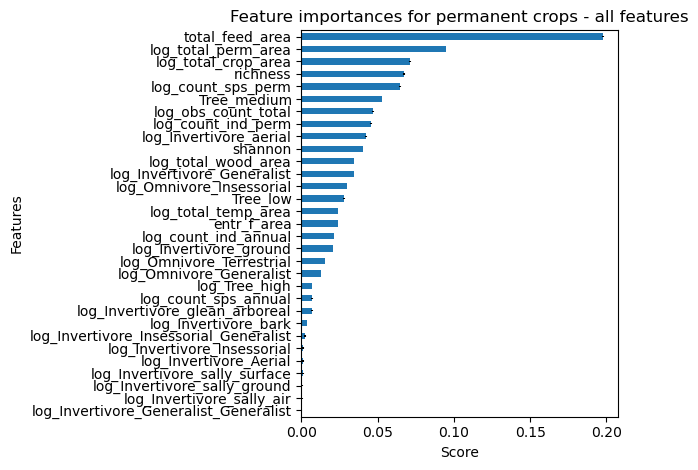

In [11]:
# plot feature importance
features_importances = pd.Series(importances, index=feature_names)
v = features_importances.sort_values(ascending=True)

fig, ax = plt.subplots()
v.plot.barh(yerr=std, ax=ax)
ax.set_title("Feature importances for permanent crops - all features")
ax.set_xlabel("Score")
ax.set_ylabel("Features")
fig.tight_layout()
plt.savefig('../output/figures/feature_importance_perm.png', dpi=300, bbox_inches='tight')
plt.show()


In [12]:
features_importances

log_count_ind_annual                      2.151363e-02
log_count_ind_perm                        4.536199e-02
log_count_sps_annual                      6.802876e-03
log_obs_count_total                       4.723891e-02
log_count_sps_perm                        6.494805e-02
shannon                                   4.034995e-02
richness                                  6.712355e-02
log_Tree_high                             6.903442e-03
Tree_low                                  2.785308e-02
Tree_medium                               5.305875e-02
log_Invertivore_Generalist_Generalist     6.438346e-07
log_Invertivore_Insessorial               1.225179e-03
log_Invertivore_sally_ground              6.523212e-04
log_Invertivore_sally_surface             7.825723e-04
log_Invertivore_sally_air                 4.092636e-04
log_Invertivore_Aerial                    1.184530e-03
log_Invertivore_bark                      3.722014e-03
log_Invertivore_Generalist                3.440488e-02
log_Invert

We will also prepare a biplot between the calculated and predicted pest consumption values, for the test subset.

<Axes: xlabel='log_point_cons_perm_ha'>

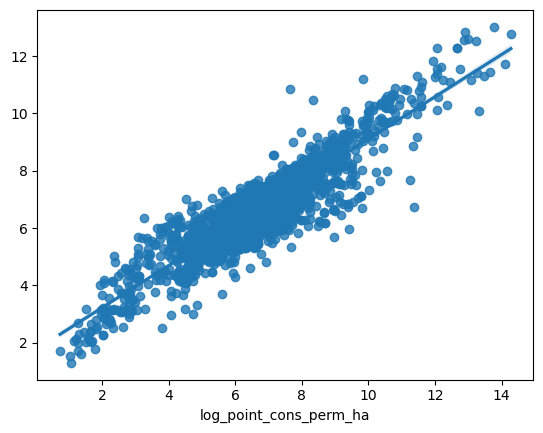

In [13]:
sns.regplot(x=y_test, y=prediction)

### 3. Make the feature selection

As we observed in the feature contribution graph, not all contribute to the model. We will make a feature selection, to simplify our model.

In [14]:
from sklearn.feature_selection import SelectFromModel

# Create and train the RandomForestRegressor model
rf_model = RandomForestRegressor(max_depth=7, max_features='sqrt', n_estimators=700,
                      random_state=18)
rf_model.fit(X_train, y_train)

# Create a SelectFromModel object with the pre-trained RandomForestRegressor
sfm = SelectFromModel(rf_model, threshold='median')

# Fit the SelectFromModel to select important features
sfm.fit(X_train, y_train)

# Transform the feature set to keep only the selected features
X_train_selected = sfm.transform(X_train)
X_test_selected = sfm.transform(X_test)

# Retrieve the support mask (a boolean array indicating selected features)
support = sfm.get_support()

# Print selected features
print("Selected features:")
for i, selected in enumerate(support):
    if selected:
        print(f"Feature {i}: importance {rf_model.feature_importances_[i]}")
        


selected_features = np.array(feature_names)[support]

Selected features:
Feature 0: importance 0.01733381309867847
Feature 1: importance 0.04213478218218257
Feature 3: importance 0.04580266936099597
Feature 4: importance 0.07521962340186086
Feature 5: importance 0.04340028873260343
Feature 6: importance 0.07835741814893497
Feature 8: importance 0.025567994021238716
Feature 9: importance 0.05451048956775595
Feature 17: importance 0.032965840788410285
Feature 22: importance 0.03292003149207281
Feature 23: importance 0.039295661848848
Feature 26: importance 0.07256408043546872
Feature 27: importance 0.21025644428884546
Feature 28: importance 0.030065050391939963
Feature 29: importance 0.020326641871018472
Feature 30: importance 0.09895212352646032


In [15]:
selected_features

array(['log_count_ind_annual', 'log_count_ind_perm',
       'log_obs_count_total', 'log_count_sps_perm', 'shannon', 'richness',
       'Tree_low', 'Tree_medium', 'log_Invertivore_Generalist',
       'log_Omnivore_Insessorial', 'log_Invertivore_aerial',
       'log_total_crop_area', 'total_feed_area', 'log_total_wood_area',
       'log_total_temp_area', 'log_total_perm_area'], dtype=object)

There are 16 features that pass the importance criteria to be used in the model. The list above prints their names.


### 4. Create the final model

Let's create the model with the final set of features selected.

In [16]:
feature_vars = list(selected_features)

In [17]:
X = df_to_model[feature_vars]

In [18]:
X.columns

Index(['log_count_ind_annual', 'log_count_ind_perm', 'log_obs_count_total',
       'log_count_sps_perm', 'shannon', 'richness', 'Tree_low', 'Tree_medium',
       'log_Invertivore_Generalist', 'log_Omnivore_Insessorial',
       'log_Invertivore_aerial', 'log_total_crop_area', 'total_feed_area',
       'log_total_wood_area', 'log_total_temp_area', 'log_total_perm_area'],
      dtype='object')

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X.values, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (8729, 16) (8729,)
Test set: (2183, 16) (2183,)


In [20]:
# Create the RF object
from sklearn.ensemble import RandomForestRegressor
feature_names = X.columns
model_rf = RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=700,
                      random_state=18)
model_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=700,
                      random_state=18)

### 5. Make a cross validation

The cross validation allows to evaluate for possible over-fitting of the model. The procedure is to divide the training in a certain number of subsets, and use at at time to perform a test of the model.

In [21]:
%%time
# perform cross validation, using r2 as metrics
from sklearn.model_selection import cross_val_score

num_folds = 5
scores = cross_val_score(model_rf, X_train, y_train, cv=num_folds, scoring='r2', n_jobs=6)

CPU times: user 17.4 ms, sys: 52.8 ms, total: 70.3 ms
Wall time: 5.68 s


In [22]:
# CV scores
scores

array([0.78191846, 0.818497  , 0.79536873, 0.79911673, 0.80974954])

In [23]:
# CV scores mean and standard deviation
print(np.mean(scores))
print(np.std(scores))

0.8009300890222508
0.012506303090681696


The scores of the five CV runs are similar, and give good expalation rate to the variance, indicating that there is no obvious overfitting in the model.

Next, we print the performance metrics of the model.

In [24]:
prediction = model_rf.predict(X_test)
print(get_error(y_test, prediction))

{'test mse': 0.6961949340808387, 'rmse': 0.8343829660778309, 'perc_rmse': 12.426297426421318, 'mae': 0.5902897936679601, 'perc_mae': 8.79106698256197, 'r2': 0.8004286971120282}


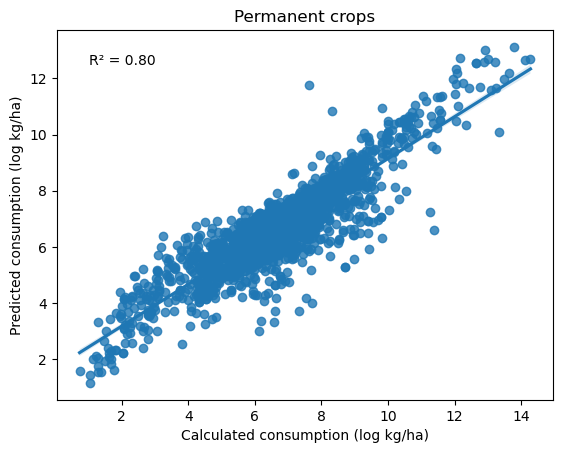

In [25]:
biplot = sns.regplot(x=y_test, y=prediction)
biplot.set_title('Permanent crops')
biplot.set_xlabel('Calculated consumption (log kg/ha)')
biplot.set_ylabel('Predicted consumption (log kg/ha)')
plt.annotate('R\u00b2 = {:.2f}'.format(round(r2_score(y_test,prediction), 2)), xy=(1, 10), xytext=(1, 12.5))
plt.show()
biplot.figure.savefig('../output/figures/biplot_validation_perm.png', dpi=300, bbox_inches='tight')

In [26]:
# save X_test and prediction to evaluate the simulation
df_X_test = pd.DataFrame(X_test) 
df_X_test.to_csv('../process_data/X_test_perm.csv')
df_y_test = pd.DataFrame(y_test)
df_y_test.to_csv('../process_data/y_test_perm.csv')

### 6. Feature importance of the final model

In [27]:
import time

start_time = time.time()
importances = model_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_rf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.053 seconds


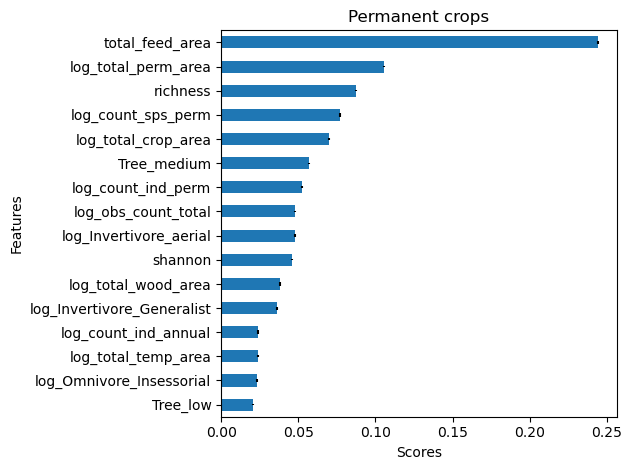

In [28]:
features_importances = pd.Series(importances, index=feature_names)
v = features_importances.sort_values(ascending=True)

fig, ax = plt.subplots()
v.plot.barh(yerr=std, ax=ax)
ax.set_title("Permanent crops")
ax.set_xlabel("Scores")
ax.set_ylabel("Features")
plt.savefig('../output/figures/feature_importance_perm_sel.png', dpi=300, bbox_inches='tight')
fig.tight_layout()

In [29]:
# save model for later use
import joblib

filename = '../models/perm_crops.joblib'
joblib.dump(model_rf, filename)

['../models/perm_crops.joblib']

In [30]:
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [31]:
X_train

array([[0.69314718, 1.60943791, 1.60943791, ..., 0.0861777 , 0.43178242,
        0.0861777 ],
       [1.60943791, 1.60943791, 1.60943791, ..., 4.81907116, 0.3074847 ,
        0.16551444],
       [4.02535169, 4.04305127, 4.04305127, ..., 2.17815501, 3.26575941,
        3.54817957],
       ...,
       [1.79175947, 2.30258509, 2.30258509, ..., 0.2390169 , 4.97175586,
        4.55440307],
       [3.29583687, 3.33220451, 3.33220451, ..., 0.        , 4.38564508,
        1.0612565 ],
       [1.09861229, 1.09861229, 1.09861229, ..., 0.77472717, 0.2390169 ,
        0.16551444]])

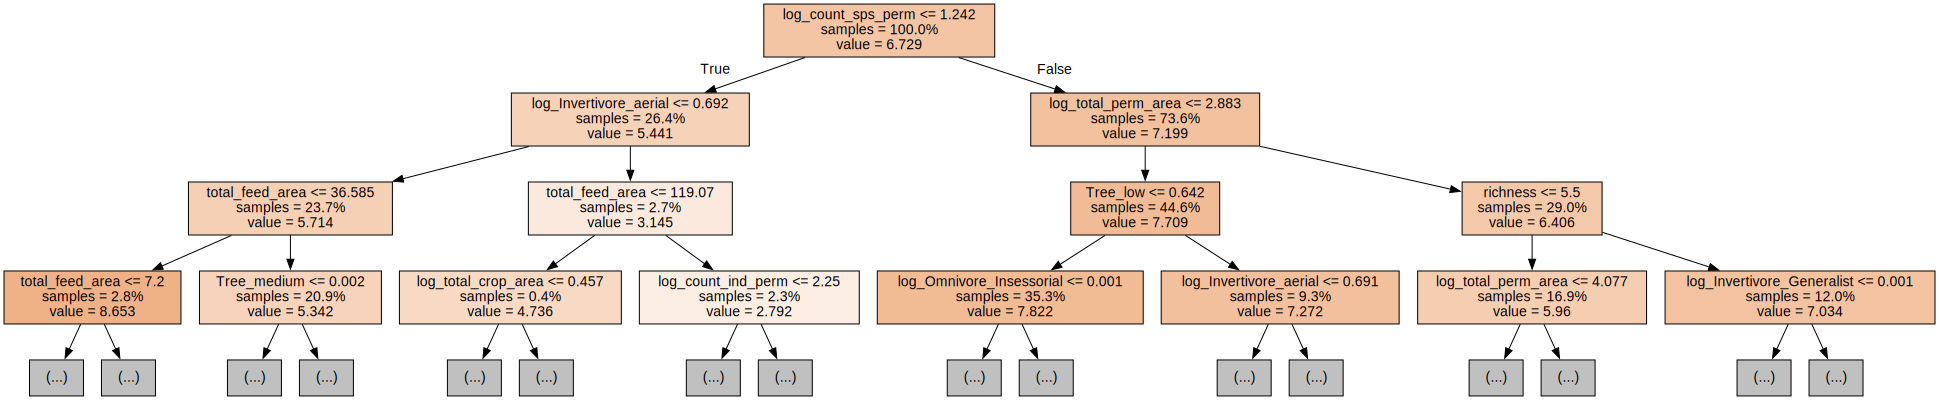

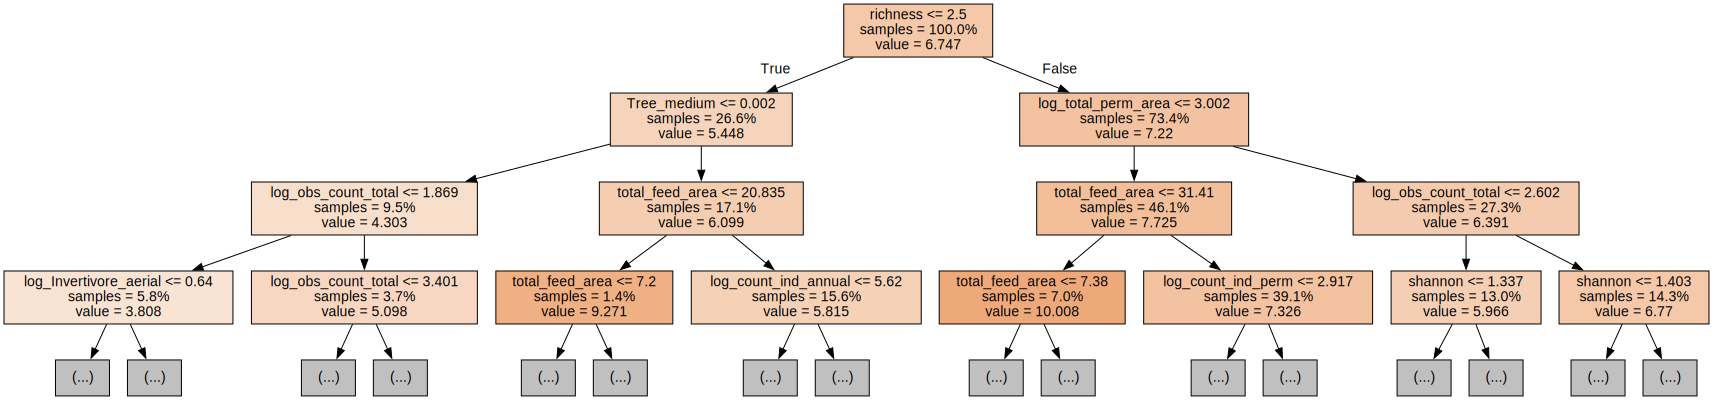

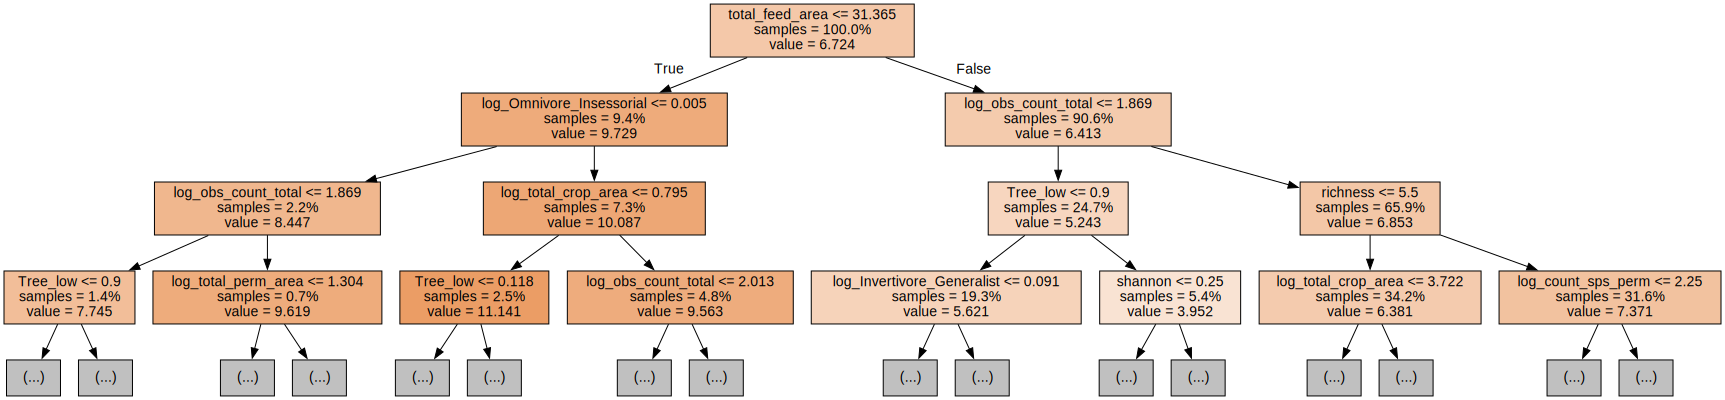

In [32]:
# Export the first three decision trees from the forest

for i in range(3):
    tree = model_rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=feature_names,  
                               filled=True,  
                               max_depth=3, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

### 7. Partial Dependence Plots

Partial dependence plots help to get an insight on what is the interaction between a feature and the predicted variable.

In [33]:
feature_names

Index(['log_count_ind_annual', 'log_count_ind_perm', 'log_obs_count_total',
       'log_count_sps_perm', 'shannon', 'richness', 'Tree_low', 'Tree_medium',
       'log_Invertivore_Generalist', 'log_Omnivore_Insessorial',
       'log_Invertivore_aerial', 'log_total_crop_area', 'total_feed_area',
       'log_total_wood_area', 'log_total_temp_area', 'log_total_perm_area'],
      dtype='object')

16


/usr/lib64/python3.11/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


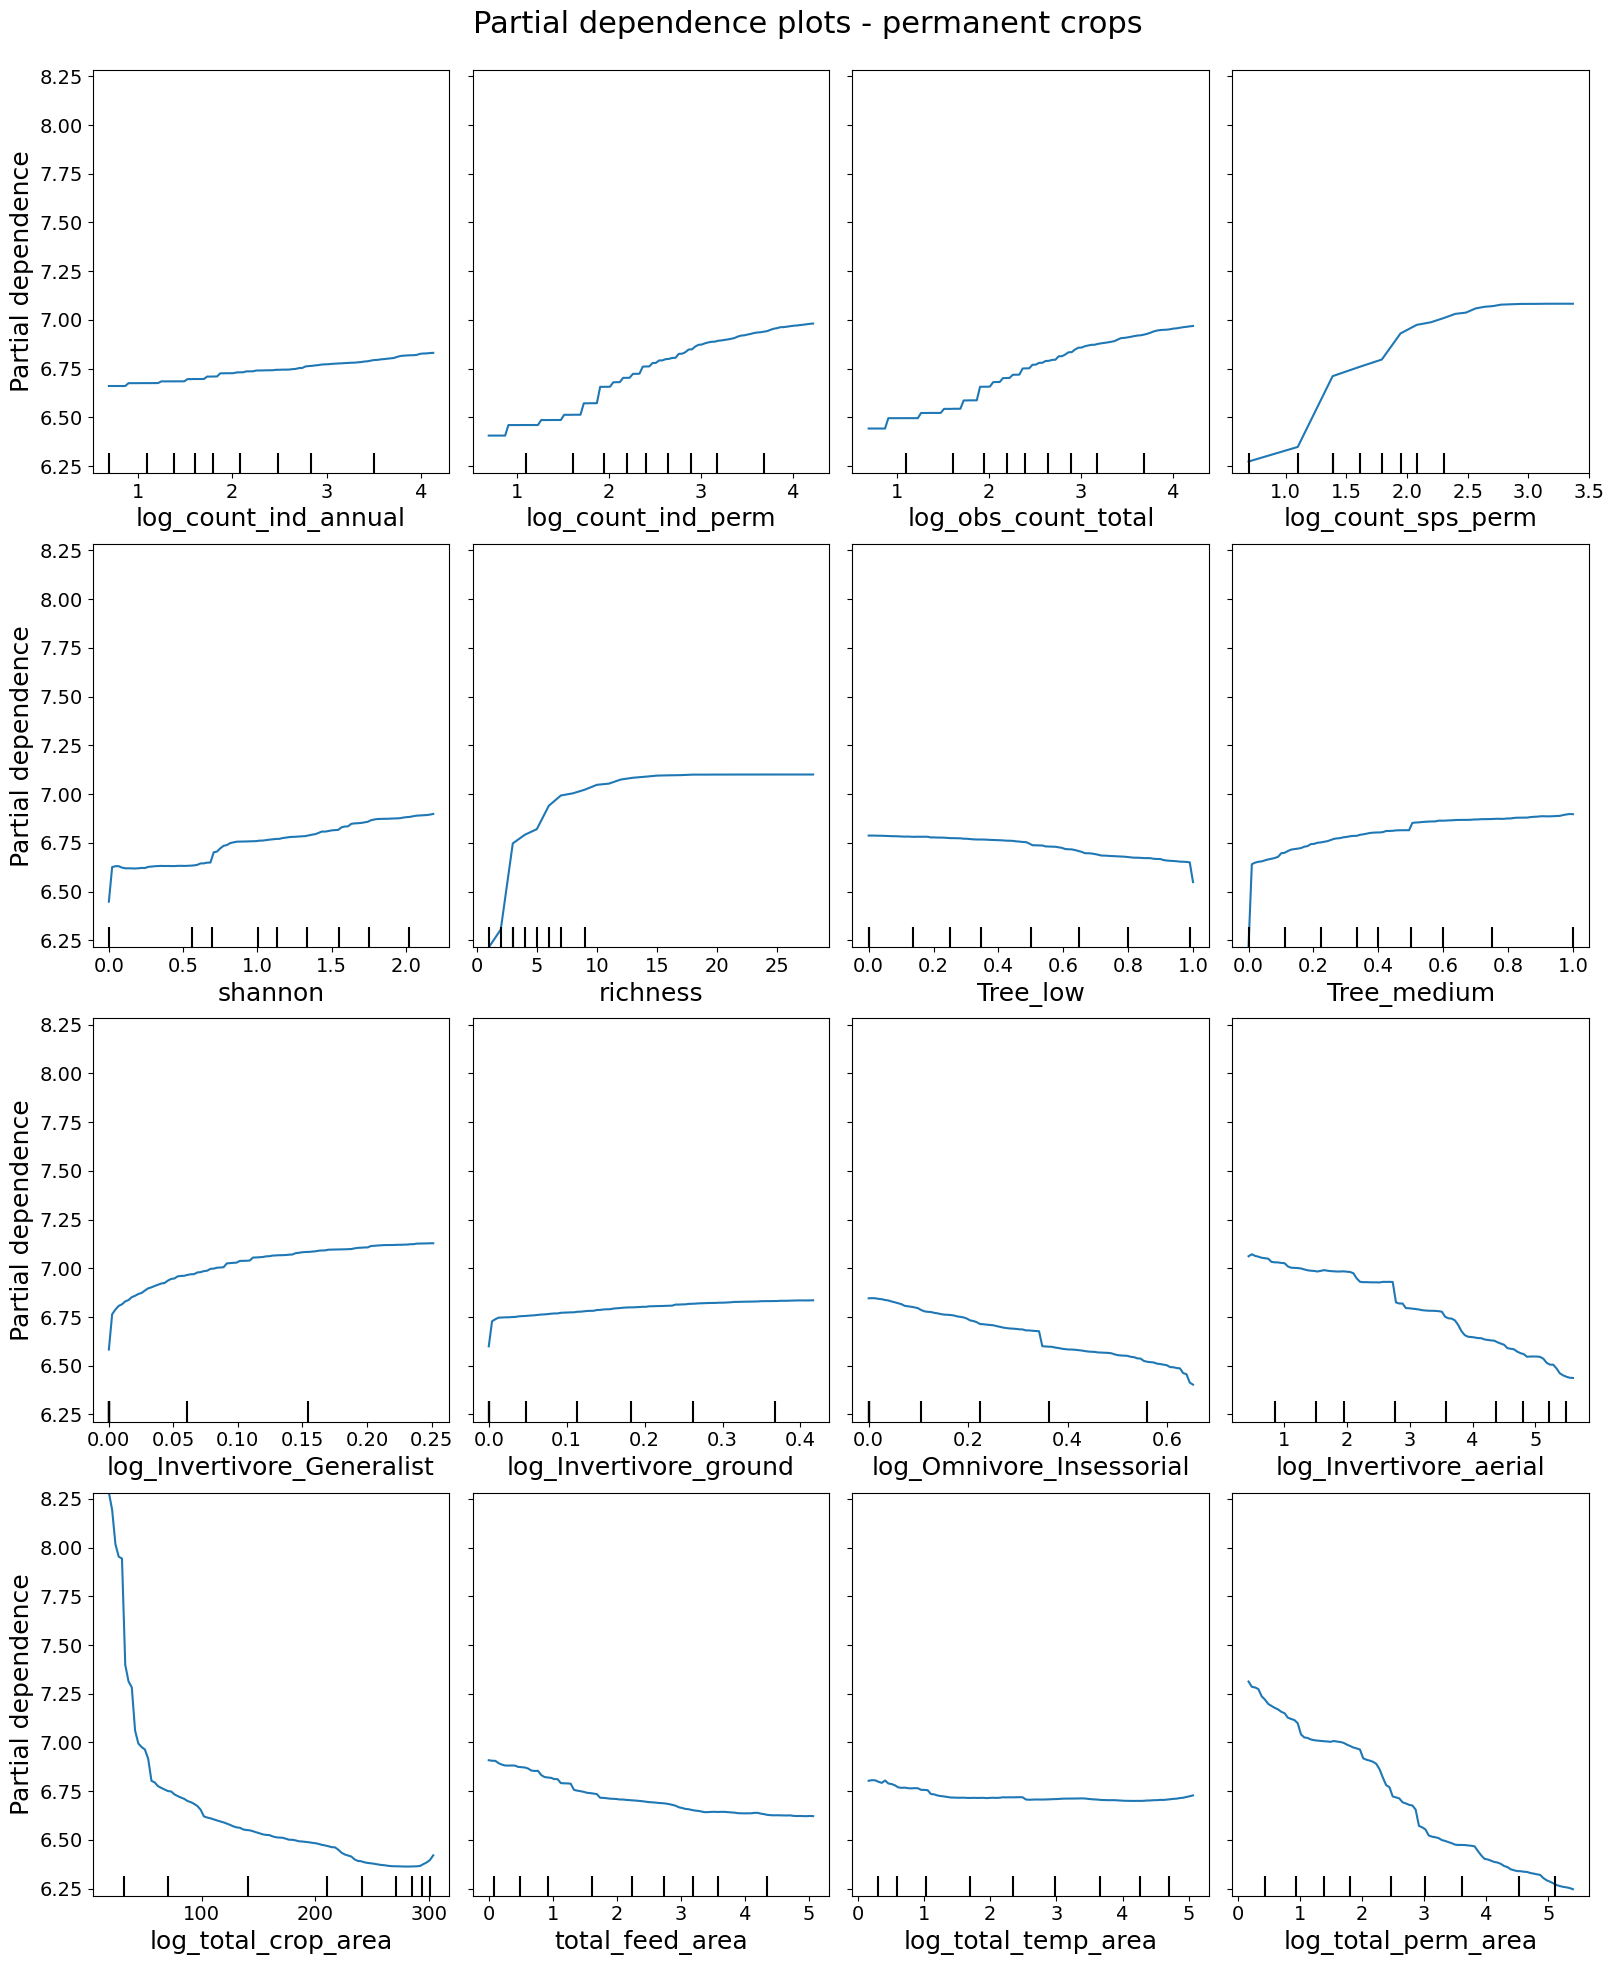

In [34]:
# Partial Dependency plots
from sklearn.inspection import plot_partial_dependence

feature_names = ['log_count_ind_annual',
 'log_count_ind_perm',
 'log_obs_count_total',
 'log_count_sps_perm',
 'shannon',
 'richness',
 'Tree_low',
 'Tree_medium',
 'log_Invertivore_Generalist',
 'log_Invertivore_ground',
 'log_Omnivore_Insessorial',
 'log_Invertivore_aerial',
 'log_total_crop_area',
 'total_feed_area',
 'log_total_temp_area',
 'log_total_perm_area']

print(len(feature_names))

# Select the features for which you want to create PDPs (replace with your feature indices)
features_to_plot = list(range(0, 16))

# set font size
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)

# Create partial dependence plots
fig, ax = plt.subplots(4,4, figsize=(16, 20))
plot_partial_dependence(model_rf, X_train, features=features_to_plot, feature_names=feature_names, ax=ax)
plt.tight_layout()
fig.subplots_adjust(top=0.95)
fig.suptitle("Partial dependence plots - permanent crops", fontsize=22)
plt.rc('axes', labelsize=18)
plt.savefig('../output/figures/partial_dep_perm.png', dpi=300, bbox_inches='tight')
plt.show()